In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
# import general_functions as gf
from tqdm import tqdm

In [3]:
# Parameter values
# State values
tau = 50
refractory_state = tau
resting_state = 0
excited_state = -tau
# Dysfunctional values
dysfunctional_value = 1
not_dysfunctional_value = 0
# Connected to above or not
connected_above_value = 1
not_connected_above_value = 0
# Info
info_state_idx = 0
info_dysfuntional_idx = 1
info_connected_above_idx = 2

In [7]:
def initial_structure(L, nu, delta):
    # L: int - length of cell sheet
    # nu: float - probability for cell to be connected to the cell above it
    # delta: float - probablity to be dysfunctional

    # Cell info consists of three LxL matrices containing the following:
        # State: resting, excited, refractory
        # Dysfunctional or not
        # Connected to above or not

    cell_info = np.empty((L, L, 3))
    # States
    cell_info[:, :, info_state_idx] = resting_state
    cell_info[:, 0, info_state_idx] = excited_state  # Left boundary is pacemaker.
    # Dysfunctional
    cell_info[:, :, info_dysfuntional_idx] = np.random.choice(a=[dysfunctional_value, not_dysfunctional_value], p=[delta, 1-delta], replace=True, size=(L, L))
    # Connected to above
    cell_info[:, :, info_connected_above_idx] = np.random.choice(a=[connected_above_value, not_connected_above_value], p=[nu, 1-nu], replace=True, size=(L, L))

    return cell_info


def excite_nbors(target_idx, cell_info, epsilon):
    # Find and potentially excite neighbours
    L = np.shape(cell_info)[0]
    
    x = target_idx[0]
    y = target_idx[1]
    
    nbor_left = (x, max(y - 1, 0))
    nbor_right = (x, min(y + 1, L - 1))
    
    nbor_down = ((x + L + 1) % L, y)
    nbor_up = ((x + L - 1) % L, y)
    
    
    # Open boundary for horizontal direction
    # Periodic boundary for vertical direction
    # Check if vertically connected. If not, set "neighbour" to be itself

    if cell_info[*nbor_up, info_connected_above_idx] == not_connected_above_value:
        nbor_up = (x, y)
    if cell_info[*target_idx, info_connected_above_idx] == not_connected_above_value:
        nbor_down = (x, y)

    # Excite neighbours which are in relaxed state.
    # Take dysfunctional cells into account
    for nbor_idx in [nbor_left, nbor_right, nbor_down, nbor_up]:
        nbor_state = cell_info[*nbor_idx, info_state_idx]
        nbor_dysfunctional = cell_info[*nbor_idx, info_dysfuntional_idx]
        if nbor_state == resting_state:
            nbor_state_value = excited_state
            
            random_number = np.random.uniform(low=0, high=1)
            did_not_work = random_number < epsilon
            if nbor_dysfunctional == dysfunctional_value and did_not_work:
                nbor_state_value = cell_info[*nbor_idx, info_state_idx]
                
            cell_info[*nbor_idx, info_state_idx] = nbor_state_value
            

def reduce_refractory(cell_info):
    # get all refractory sites and reduce their value by 1
    refractory_idx = np.nonzero(cell_info[:, :, info_state_idx] > resting_state)
    cell_info[*refractory_idx, info_state_idx] -= 1


def pacemaker_activation(t: int, cell_info: np.ndarray, T=40):
    """Every T time steps, activate the pacemaker (the leftmost column).

    Args:
        t (int): Current time
        cell_info (np.ndarray): Cell state and more
        T (_type_, optional): How often the pacemaker activates. Defaults to int.
    """
    if t % T == 0:
        # NOTE Take dysfunctional into account
        cell_info[:, 0, info_state_idx] = excited_state  # Left boundary


def evolve(L: int, nu: float, delta: float, epsilon: float, tmax: int) -> np.ndarray:
    """AF heart simulation.

    Args:
        L (int): Length/Height of the 2d cell sheet
        nu (float): Probability of having a vertical cell connection
        delta (float): Fraction of dysfunctional cells
        epsilon (float): Probability of dysfunctional cell of not responding to excitement
        tmax (int): How many time steps to run the simulation for
    Returns:
        np.ndarray: Cell state history
    """
    cell_info = initial_structure(L, nu, delta)
    excited_cells_idx = np.where(cell_info[:, :, info_state_idx] == excited_state)
    cell_state_history = np.empty((L, L, tmax))
    cell_state_history[:, :, 0] = cell_info[:, :, info_state_idx]

    for t in tqdm(range(1, tmax)):
        # For each excited cell, attempt to excite its neighbours, then set the excited to refractory
        for i in range(np.shape(excited_cells_idx)[1]):
            cell_idx = (excited_cells_idx[0][i], excited_cells_idx[1][i])
            excite_nbors(cell_idx, cell_info, epsilon)
            cell_info[*cell_idx, info_state_idx] = refractory_state

        # Reduce refractory period
        reduce_refractory(cell_info)

        # Check for pacemaker activation
        pacemaker_activation(t, cell_info)

        # Find the new excited cells and store current state in history
        excited_cells_idx = np.where(cell_info[:, :, info_state_idx] == excited_state)
        cell_state_history[:, :, t] = cell_info[:, :, info_state_idx]

    # ADD save to file

    return cell_state_history


def plot_initial_final(L: int, nu: float, delta: float, epsilon: float, tmax: int) -> None:
    cell_state_history = evolve(L, nu, delta, epsilon, tmax)

    initial_state = cell_state_history[:, :, 0]
    final_state = cell_state_history[:, :, -1]

    fig, (ax, ax1) = plt.subplots(ncols=2)
    ax.imshow(initial_state, vmin=excited_state, vmax=refractory_state, cmap="hot")
    im = ax1.imshow(final_state, vmin=excited_state, vmax=refractory_state, cmap="hot")
    ax.set(title="Initial")
    ax1.set(title="Final")

    cbar = fig.colorbar(im)
    cbar.set_ticks([excited_state, resting_state, refractory_state])
    cbar.set_ticklabels(["Excited", "Resting", "Refractory"])
    # Figtitle
    fig.suptitle(f"Time = {np.shape(cell_state_history)[2]}")

    # figname = dir_path_image + "image_plot.png"
    # plt.savefig(figname)
    plt.show()


def animate_state(L: int, nu: float, delta: float, epsilon: float, tmax: int) -> None:
    cell_state_history = evolve(L, nu, delta, epsilon, tmax)

    fig, ax = plt.subplots()
    im = ax.imshow(cell_state_history[:, :, 0], cmap="hot", vmin=excited_state, vmax=refractory_state)
    cbar = fig.colorbar(im)
    cbar.set_ticks([excited_state, resting_state, refractory_state])
    cbar.set_ticklabels(["Excited", "Resting", "Refractory"])

    def animate(i):
        current_image = cell_state_history[:, :, i]
        ax.set_title(f"Time = {i}")
        im.set_array(current_image)
        return [im]

    anim = FuncAnimation(fig, animate, interval=100, frames=tmax)
    anim.save('heart_animation.gif', dpi=100)
    plt.show()

100%|████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 2314.84it/s]
MovieWriter ffmpeg unavailable; using Pillow instead.


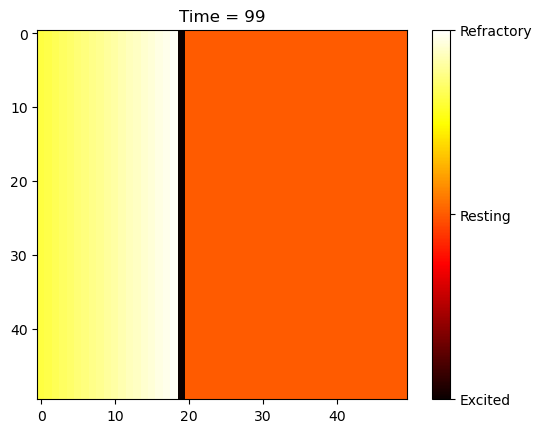

In [8]:
# plot_initial_final(L=50, nu=1, delta=0, epsilon=0, tmax=100)
animate_state(L=50, nu=1, delta=0, epsilon=0, tmax=100)